## Trip Prediciton
Done by Aaron Kurian Manoj Philipose


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore") # Suppress unnecessary warnings for cleaner output

#Load and Preprocess Data 
#ist all the files to be loaded
file_names = [
    "202402-citibike-tripdata_3.csv",
    "202102-citibike-tripdata_1.csv", 
    "201701-citibike-tripdata.csv_1.csv",
    "202105-citibike-tripdata_3.csv", 
    "202108-citibike-tripdata_2.csv",
    "202108-citibike-tripdata_1.csv",
    "202210-citibike-tripdata_1.csv",
    "202212-citibike-tripdata_2.csv",
    "202203-citibike-tripdata_1.csv",
    "202201-citibike-tripdata_1.csv",
    "202312-citibike-tripdata_3.csv",
    "202312-citibike-tripdata_1.csv",
    "202303-citibike-tripdata_2.csv",
    "202308-citibike-tripdata_2.csv",
    "202308-citibike-tripdata_1.csv"
    
]

data_frames = []
column_mapping = {
    'starttime': 'started_at', 
    'stoptime': 'ended_at',
    'start station name': 'start_station_name',
    'end station name': 'end_station_name',
    'start station id': 'start_station_id',
    'end station id': 'end_station_id',
    'start station latitude': 'start_lat',
    'start station longitude': 'start_lng',
    'end station latitude': 'end_lat',
    'end station longitude': 'end_lng',
    'birth year': 'birth_year', #Used for standardization, though not used in the model
    'gender': 'gender', #used for standardization, though not used in the model
    'usertype': 'member_casual',
}

for file in file_names:
    print(f"Loading {file}...")
    temp_df = pd.read_csv(file, low_memory=False)
    
    #standardize column names across all years (e.g., mapping old names to new names)
    temp_df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
    temp_df.rename(columns=column_mapping, inplace=True)
    
    #standardize the member_casual column
    if 'member_casual' in temp_df.columns:
        temp_df['member_casual'] = temp_df['member_casual'].replace({'Subscriber': 'member', 'Customer': 'casual'})
    
    data_frames.append(temp_df)

#combine all into one single DataFrame
df = pd.concat(data_frames, ignore_index=True)

print(f"\nTotal trips loaded: {len(df):,}")

#cleaning
df['started_at'] = pd.to_datetime(df['started_at'], errors='coerce')
df['ended_at'] = pd.to_datetime(df['ended_at'], errors='coerce')
df = df.dropna(subset=['started_at', 'ended_at']) # Drop rows where time is missing/invalid

#trip Prediction (Demand Forecasting) 
print("\nTask 3.2: Demand Prediction (Random Forest Regression)")

#aggregate and feature engineering
df['date_hour'] = df['started_at'].dt.floor('H')
hourly_demand = df.groupby('date_hour').size().reset_index(name='trip_count')

hourly_demand['hour'] = hourly_demand['date_hour'].dt.hour
hourly_demand['day_of_week'] = hourly_demand['date_hour'].dt.dayofweek
hourly_demand['is_weekend'] = hourly_demand['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

#creating lag features (critical for time series)
hourly_demand['lag_1h'] = hourly_demand['trip_count'].shift(1)
hourly_demand['lag_24h'] = hourly_demand['trip_count'].shift(24)

model_data = hourly_demand.dropna()

# split data: train on 2021, test on 2024 
#this leverages the multiple files loaded.
train_data = model_data[model_data['date_hour'].dt.year == 2021]
test_data = model_data[model_data['date_hour'].dt.year == 2024]

features = ['hour', 'day_of_week', 'is_weekend', 'lag_1h', 'lag_24h']
target = 'trip_count'

# model training and prediction
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(train_data[features], train_data[target])

predictions = rf_model.predict(test_data[features])

# evaluate model
mae = mean_absolute_error(test_data[target], predictions)
rmse = np.sqrt(mean_squared_error(test_data[target], predictions))

print(f"Prediction Performance (Trained on 2021, Tested on 2024):")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")

Loading 202402-citibike-tripdata_3.csv...
Loading 202102-citibike-tripdata_1.csv...
Loading 201701-citibike-tripdata.csv_1.csv...
Loading 202105-citibike-tripdata_3.csv...
Loading 202108-citibike-tripdata_2.csv...
Loading 202108-citibike-tripdata_1.csv...
Loading 202210-citibike-tripdata_1.csv...
Loading 202212-citibike-tripdata_2.csv...
Loading 202203-citibike-tripdata_1.csv...
Loading 202201-citibike-tripdata_1.csv...
Loading 202312-citibike-tripdata_3.csv...
Loading 202312-citibike-tripdata_1.csv...
Loading 202303-citibike-tripdata_2.csv...
Loading 202308-citibike-tripdata_2.csv...
Loading 202308-citibike-tripdata_1.csv...

Total trips loaded: 11,951,937

Task 3.2: Demand Prediction (Random Forest Regression)
Prediction Performance (Trained on 2021, Tested on 2024):
MAE (Mean Absolute Error): 67.90
RMSE (Root Mean Squared Error): 115.53


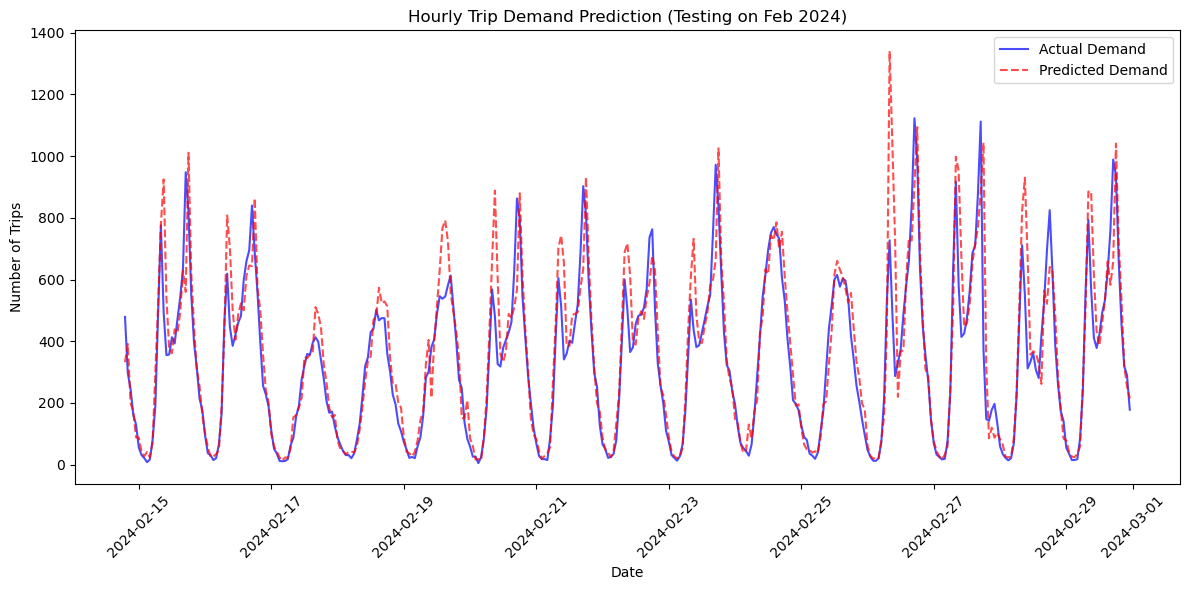

In [2]:
#plot actual vs predicted 
plt.figure(figsize=(12, 6))
plt.plot(test_data['date_hour'], test_data[target], label='Actual Demand', color='blue', alpha=0.7)
plt.plot(test_data['date_hour'], predictions, label='Predicted Demand', color='red', linestyle='--', alpha=0.7)
plt.title('Hourly Trip Demand Prediction (Testing on Feb 2024)')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Task 3.4: Time Series Clustering of Stations (K-Means) ---


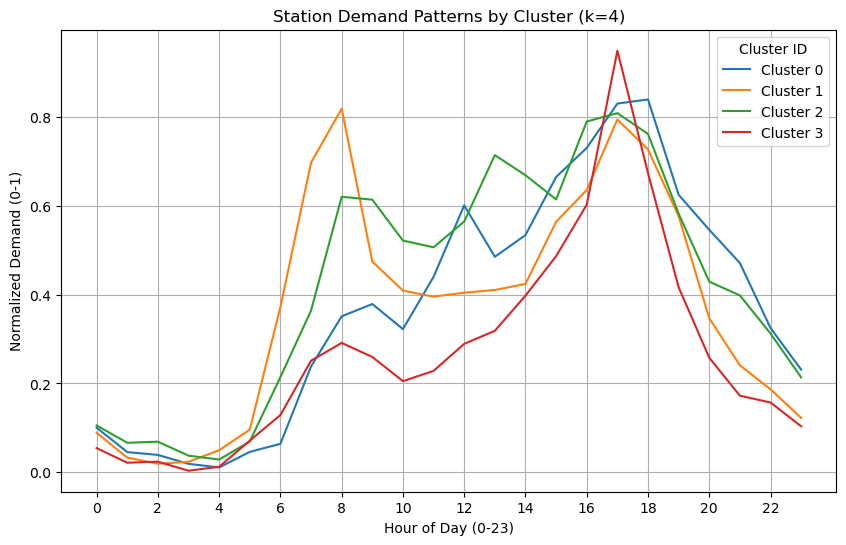

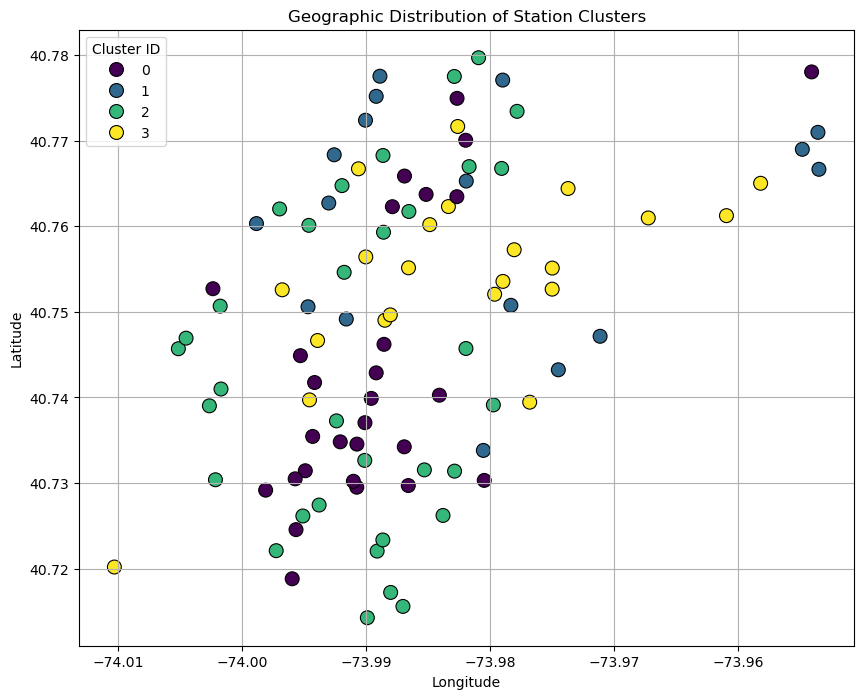

In [3]:
#Time Series Clustering of Stations
print("\nTask 3.4: Time Series Clustering of Stations (K-Means) ---")

#Prepare Data: get hourly demand pattern per station using 2024 data
df_2024 = df[df['started_at'].dt.year == 2024].copy()

# filter for top stations
top_stations = df_2024['start_station_name'].value_counts().head(100).index
df_top = df_2024[df_2024['start_station_name'].isin(top_stations)].copy()
df_top['hour'] = df_top['started_at'].dt.hour

# average trips per hour for each station across the month
station_hourly = df_top.groupby(['start_station_name', 'hour']).size().reset_index(name='count')
station_pivot = station_hourly.pivot(index='start_station_name', columns='hour', values='count').fillna(0)

#Normalize Data
# Scale each station's 24-hour pattern row-wise to cluster by *shape* (e.g., morning/evening peaks)
scaler = MinMaxScaler()
station_normalized_np = scaler.fit_transform(station_pivot.T).T
station_normalized = pd.DataFrame(
    station_normalized_np,
    index=station_pivot.index,
    columns=station_pivot.columns
)

#Clustering
k = 4 # Increased to 4 clusters to potentially capture more nuanced patterns
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(station_normalized)

#Visualization
# Plot the "Average Pattern" for each cluster 
plt.figure(figsize=(10, 6))
for i in range(k):
    plt.plot(kmeans.cluster_centers_[i], label=f'Cluster {i}')
plt.title(f'Station Demand Patterns by Cluster (k={k})')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Normalized Demand (0-1)')
plt.legend(title='Cluster ID')
plt.xticks(range(0, 24, 2))
plt.grid(True)
plt.show()

#Map the Clusters
#Get unique station coordinates from the 2024 data
station_locs = df_2024[['start_station_name', 'start_lat', 'start_lng']].drop_duplicates('start_station_name')
station_locs = station_locs.groupby('start_station_name').mean().reset_index()

# Merge cluster labels with coordinates
map_data = pd.DataFrame({'cluster': clusters}, index=station_normalized.index).reset_index()
map_data = pd.merge(map_data, station_locs, on='start_station_name')

#scatter plot (lat/lon) 
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=map_data, x='start_lng', y='start_lat', 
    hue='cluster', palette='viridis', s=100, edgecolor='black'
)
plt.title('Geographic Distribution of Station Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()

In [4]:
#Creating a map
!pip install folium
import folium
from folium.plugins import MarkerCluster
import matplotlib.cm as cm
import matplotlib.colors as colors

# base map of nyc
nyc_center = [40.7128, -74.0060]
m = folium.Map(location=nyc_center, zoom_start=12, tiles='CartoDB positron')

# assigning colors for clusters
num_clusters = map_data['cluster'].nunique()
colormap = cm.get_cmap('viridis', num_clusters)
cluster_colors = {
    i: colors.to_hex(colormap(i)) for i in range(num_clusters)
}

#for cleaner view
marker_cluster = MarkerCluster().add_to(m)

# plot stations
for _, row in map_data.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=6,
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        color='black',
        weight=1,
        popup=f"Station: {row['start_station_name']}<br>Cluster: {row['cluster']}"
    ).add_to(marker_cluster)

#add legends
legend_html = '''
<div style="
    position: fixed; 
    bottom: 40px; left: 40px; width: 180px; height: auto; 
    background-color: white; z-index:9999; 
    border:2px solid grey; border-radius:8px;
    padding: 10px; font-size:14px;">
    
<b>Cluster Legend</b><br>
{}
</div>
'''

legend_items = ""
for c in cluster_colors:
    color = cluster_colors[c]
    legend_items += f'<span style="display:inline-block;width:15px;height:15px;background:{color};margin-right:5px;"></span>Cluster {c}<br>'

m.get_root().html.add_child(folium.Element(legend_html.format(legend_items)))

m


## Insights and Interpretations from Visualizations

### 1. Hourly Trip Demand Prediction (Random Forest Model) 

* **Interpretation:** The Hourly Trip Demand Prediction graph  compares the Actual Demand (blue solid line) against the Predicted Demand (red dashed line) for February 2024. This model captures the strong daily and weekly periodicity in the data, showing low demand overnight and high peaks during the day.
* **Insight:** The model is generally accurate in predicting low and moderate demand hours. However, it frequently underestimates the highest peaks (e.g., around Feb 26th and 27th) and sometimes overestimates the troughs between peaks (e.g., Feb 18th morning). This indicates that while the hour-of-day and day-of-week features are strong, the model may be missing external factors (like weather, specific events, or anomalies) that drive extreme, high-magnitude spikes. This explains the Root Mean Squared Error (RMSE) being significantly higher than the Mean Absolute Error (MAE), as the large errors on the peaks are penalized heavily by the squared term in RMSE.

---

### 2. Station Demand Patterns by Cluster (K-Means) 

* **Interpretation:** The K-Means clustering ($k=4$) on station demand profiles  reveals four distinct types of usage patterns:
    * **Cluster 1 (Commuter-Focused):** Shows a sharp, high peak in the morning (around 8 AM) and a second, lower peak in the late afternoon/evening (around 5 PM). This is a pattern for stations located near residential areas where users start their day with a bike trip.
    * **Cluster 2 (Evening/Leisure Peak):** Displays a very late and singular high peak, specifically around 6 PM to 7 PM, with low morning usage. This is characteristic of stations in major employment or entertainment districts that serve as destinations in the morning and origins for the evening commute/leisure trip home.
    * **Cluster 0 (Moderate All-Day):** Features a broad, moderate demand profile that is relatively flat compared to the other clusters, with a subtle late-afternoon rise. This likely represents stations in mixed-use or highly tourist/leisure areas with consistent, non-commuter-dependent usage throughout the day.
    * **Cluster 3 (Mixed-Use/Errand):** Shows two distinct peaks, a smaller one in the late morning (around 10 AM) and a large peak in the evening (around 5 PM), suggesting a blend of late commuters, midday errands, and evening return trips.

---

### 3. Geographic Distribution and Operational Implications 

* **Interpretation:** The Geographic Distribution of Station Clusters Scatter plot  shows how these demand patterns are distributed across the city (based on Latitude and Longitude):
    * **Cluster 2 (Evening/Leisure Peak)** stations (Orange/Yellow in the legend, Blue/Yellow in the plot) are heavily concentrated in the*core, midtown/downtown areas of Manhattan ($\approx -73.98$ to $-74.00$ Longitude). These are the typical Central Business District (CBD) destinations.
    * **Cluster 1 (Commuter-Focused)** stations (Blue in the legend, Dark Purple in the plot) appear to be more distributed around the fringes of the core, indicating residential feeder areas and outer neighborhoods.
* **Insight:** This geographic separation directly informs bike rebalancing strategy. The system can anticipate a massive net inflow of bikes into the Cluster 2 (CBD/Destination) stations in the morning and a massive net outflow in the evening. Rebalancing operations (trucks moving bikes) should be prioritized to move bikes out of Cluster 2 in the evenings and early mornings and into Cluster 2 before the morning rush. The clustering provides a data-driven way to categorize every station for efficient resource allocation.